This notebook uses linear regression to predict the gross revenue of theater ticket and disc sales of independent movies during the years of 2008 through 2017.

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

## sklearn

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

## other

In [3]:
import scipy.stats as stats

# Plot Settings

In [4]:
# format style
plt.style.use('fivethirtyeight')
# lineweight
plt.rc('lines', linewidth=3)
# figure size
plt.rc('figure', figsize=(12, 7))
# title fontsize
plt.rc('axes', titlesize=33) 
# axes label fontsize
plt.rc('axes', labelsize=28)
# axes values fontsize
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
# legend fontsize
plt.rc('legend', fontsize=18)

# Custom Functions

## Model Evaluation Function
Function to create evaluation plots given test input

In [5]:
def lr_eval(model, X, y):
    '''
    Plot model accuracy, residuals and probability plots
    model : fitted model to evaluate
    X : test feature data
    y : test target data
    '''
    
    # output r-squared score for model
    print('R-squared:', model.score(X, y))
    
    # cacluate model residuals
    predictions = model.predict(X)
    residuals = y - predictions
    
    # evaluation plots
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(7, 20))
    ax1.scatter(y, predictions)
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Actual Value')
    ax1.set_ylabel('Predicted Value')
    ax2.scatter(predictions, residuals)
    ax2.set_title('Residual Plot')
    ax2.set_xlabel('Predicted Value')
    ax2.set_ylabel('Residual')
    stats.probplot(residuals, dist='norm', plot=plt)
    fig.tight_layout();

## Feature Weight Sorting
Function to sort feature weights from greatest to least.

In [6]:
def feat_sort(values, labels, ret_num='all'):
    '''
    Return dataframe of sorted (by absolute value) feature weights
    values : feature weight values from analysis
    labels : names of features
    ret_num : number of top features to return
    '''
    
    df = pd.DataFrame(values, index=labels, columns=['feat_wgt'])
    # drop weights = 0
    df = df[df['feat_wgt'] != 0]
    # note which weights are positive
    df['positive'] = df['feat_wgt'] > 0
    # take absolute value of weights
    df['feat_wgt'] = df['feat_wgt'].apply(abs)
    # sort weights (largest to smalles)
    df.sort_values(by='feat_wgt', ascending=False, inplace=True)
    if ret_num == 'all':
        return(df)
    else:
        return(df.iloc[:ret_num, :])

### Bar Plot

In [7]:
def feat_plot(df_feats, feat_lab='df_idx'):
    '''
    Return plot of positive and negative feature affects for a given model
    
    Parameters
    ----------
    df_feats : dataframe of a model's feature affect values and if positive
    feat_lab : labels for feature affects, default is dataframe index
    '''
    
    # define feature labels
    if feat_lab == 'df_idx':
        feat_lab = df_feats.index
    
    # initialize plot
    ax = plt.gca()
    # plot feature affects with positive and negative differentiation
    df_feats.iloc[:, 0].plot(kind='bar', ax=ax, color=df_feats.iloc[:, 1]
                            .map({True: 'g', False: 'r'}))
    ax.set_title('Linear Regression Feature Weights')
    ax.set_xlabel('Feature')
    ax.set_ylabel('Model Coefficient')
    # set x-tick labels to feature labels
    ax.set_xticklabels(feat_lab)
    
    # positive label for legend
    pos_patch = mpatches.Patch(color='green', label='Positive')
    # negative label for legend
    neg_patch = mpatches.Patch(color='red', label='Negative')
    # display legend
    legend = plt.legend(title='Correlation', handles=[pos_patch, neg_patch])
    legend.get_title().set_fontsize('18')

# Data

In [8]:
df = pd.read_csv('data/movie_data.csv')
df.head()

,title,distributor,genre,mpaa_rating,release_month,budget,runtime,num_theaters,num_days,dom_gross,intl_gross,disc_gross
0,faces places,Cohen Media Group,Documentary,PG,October,28296713.0,89.0,42.0,196.0,953717.0,953717.0,15917987.0
1,churchill,Cohen Media Group,Drama,PG,June,28296713.0,98.0,215.0,76.0,1281258.0,1281258.0,15917987.0
2,the salesman,Cohen Media Group,Drama / Thriller,PG-13,January,28296713.0,125.0,115.0,80.0,2402067.0,2402067.0,15917987.0
3,god's own country,Orion Pictures,Drama,Unrated,October,28296713.0,104.0,13.0,136.0,335609.0,335609.0,15917987.0
4,t2: trainspotting,TriStar,Crime Comedy,R,March,18000000.0,117.0,331.0,70.0,2402004.0,41681746.0,1263168.0


In [9]:
# number of observations
len(df)

2848

In [10]:
X_cat = df.iloc[:, 2:5]
X_cat.head()

,genre,mpaa_rating,release_month
0,Documentary,PG,October
1,Drama,PG,June
2,Drama / Thriller,PG-13,January
3,Drama,Unrated,October
4,Crime Comedy,R,March


In [11]:
X_num = df.iloc[:, 5:-3]
X_num.head()

,budget,runtime,num_theaters,num_days
0,28296713.0,89.0,42.0,196.0
1,28296713.0,98.0,215.0,76.0
2,28296713.0,125.0,115.0,80.0
3,28296713.0,104.0,13.0,136.0
4,18000000.0,117.0,331.0,70.0


## Target Variable
Add international gross and disc sales for total gross

In [12]:
y = df.iloc[:, -2] + df.iloc[:, -1]
y.head()

0    16871704.0
1    17199245.0
2    18320054.0
3    16253596.0
4    42944914.0
dtype: float64

## EDA

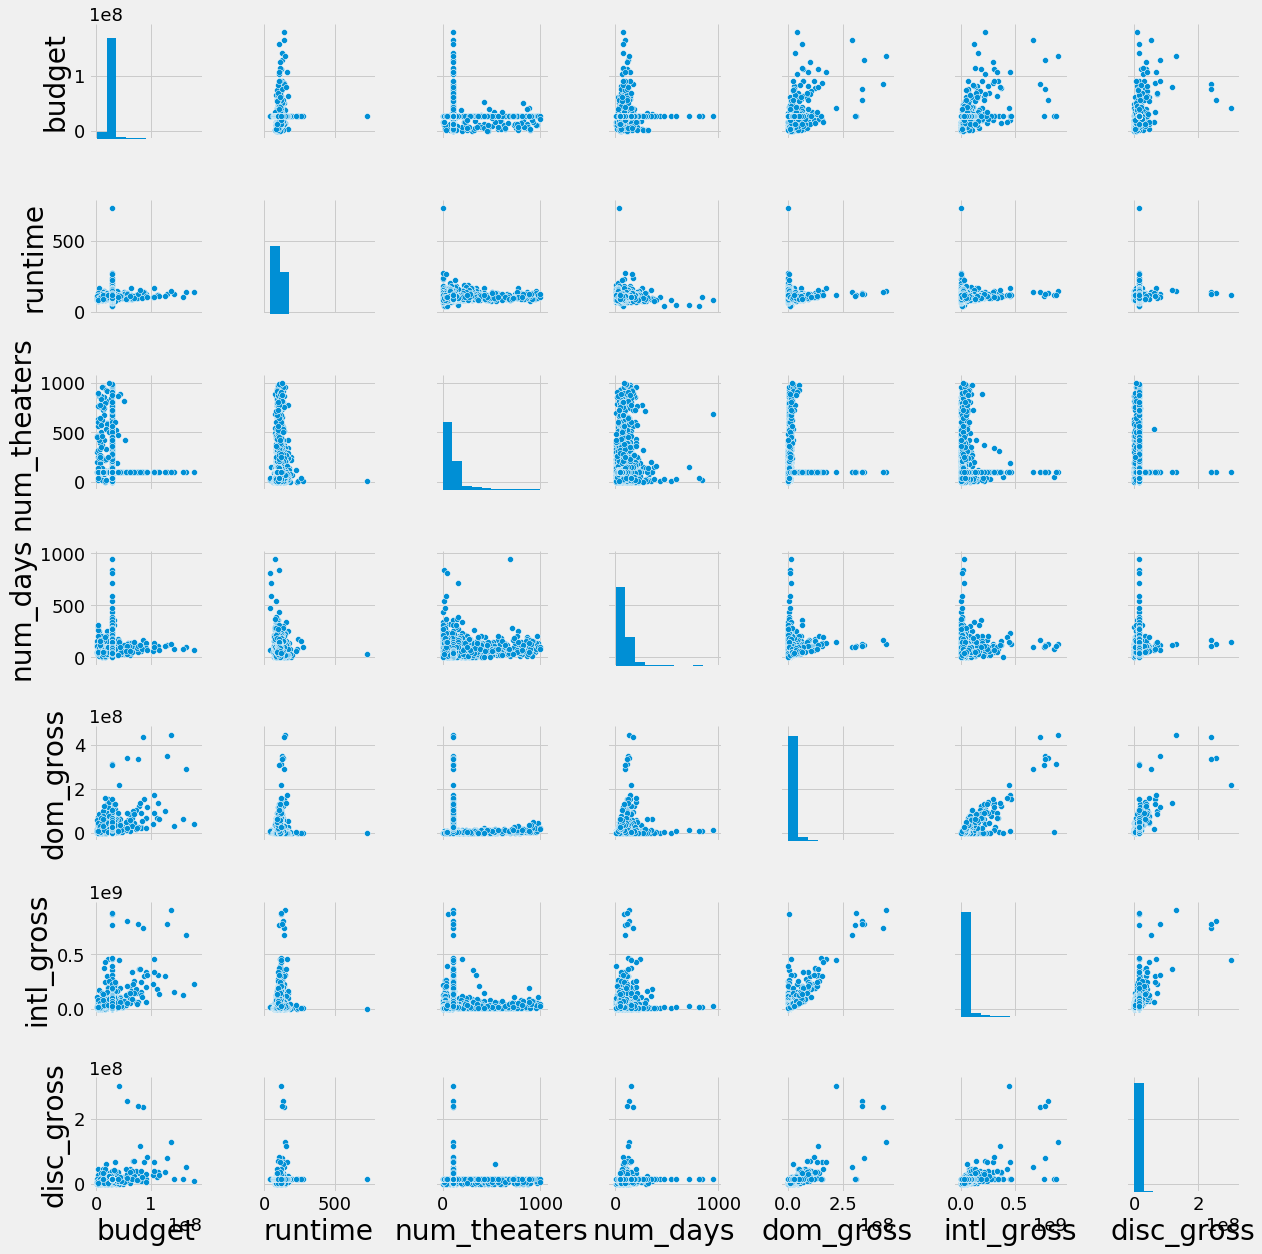

In [13]:
sns.pairplot(df);

# Pre-processing

## Categorical Data
Encode categorical features as sparse matrix of categorical labels.

In [14]:
X_cat_enc = pd.get_dummies(X_cat)
X_cat_enc.head()

,genre_Action,genre_Action / Adventure,genre_Action / Crime,genre_Action Comedy,genre_Action Drama,genre_Action Fantasy,genre_Action Horror,genre_Action Thriller,genre_Adventure,genre_Adventure Comedy,...,release_month_December,release_month_February,release_month_January,release_month_July,release_month_June,release_month_March,release_month_May,release_month_November,release_month_October,release_month_September
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Log-transformation of Numeric Data
Data is not normally distributed - try transforming to log scale

In [15]:
# transform all feature variables
X_num = np.log(X_num)

In [16]:
# transform target variable
y = np.log(y)

## Combine Categorical and Numeric Data

In [17]:
X = pd.concat([X_num, X_cat_enc], axis=1)
X.head()

,budget,runtime,num_theaters,num_days,genre_Action,genre_Action / Adventure,genre_Action / Crime,genre_Action Comedy,genre_Action Drama,genre_Action Fantasy,...,release_month_December,release_month_February,release_month_January,release_month_July,release_month_June,release_month_March,release_month_May,release_month_November,release_month_October,release_month_September
0,17.158256,4.488636,3.737670,5.278115,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,17.158256,4.584967,5.370638,4.330733,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,17.158256,4.828314,4.744932,4.382027,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,17.158256,4.644391,2.564949,4.912655,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,16.705882,4.762174,5.802118,4.248495,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Train/Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initial Modeling

In [19]:
lr_pipe = Pipeline([
    ('scaler', preprocessing.MinMaxScaler()),
    ('model', LinearRegression())
])

In [20]:
lr_pipe.fit(X_train, y_train)
lr_pipe.score(X_train, y_train)

0.3525459863112227

In [21]:
# cross-validated score
np.mean(cross_val_score(lr_pipe, X_train, y_train, cv=5))

-7.285822728104131e+19

**Very low cross-validated R-squared value**

R-squared: 0.2901931122471183


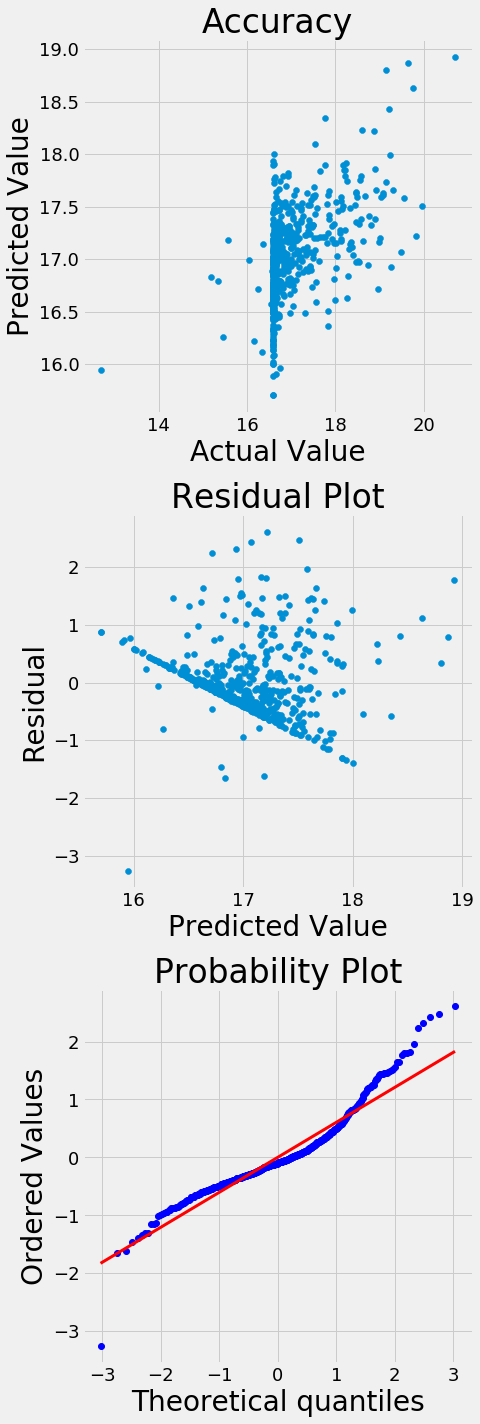

In [22]:
# plots for model evaluation
lr_eval(lr_pipe, X_test, y_test)

**Non-normal distribution of residuals  
Bowing displayed in probability plot**

# Refined Modeling
Fit of model to data may be improved by adding polynomial features. These features will capture interaction between feature variables.

In [23]:
lr_pipe = Pipeline([
    ('scaler', preprocessing.MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LinearRegression())
])

lr_pipe.fit(X_train, y_train)
lr_pipe.score(X_train, y_train)

0.6787941828950923

**Significant increase in model train score**

In [24]:
np.mean(cross_val_score(lr_pipe, X_train, y_train, cv=5))

-1.4148018645233834e+19

**Train score >> cross-validated score  
Model is overfit  
Regularization may help**

R-squared: -2.0881478458167837e+21


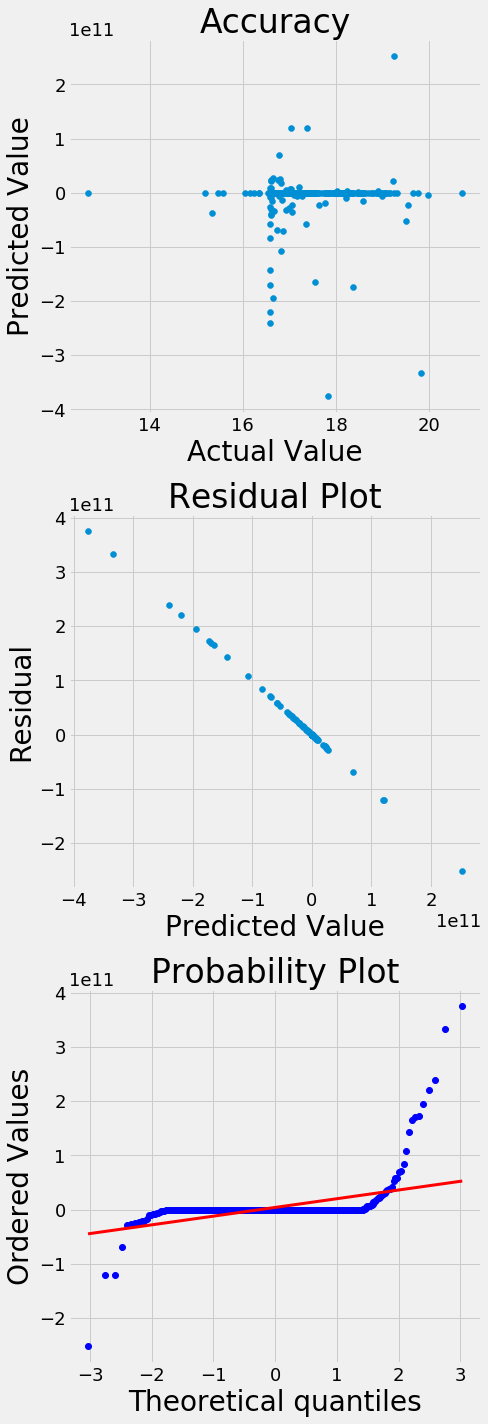

In [25]:
lr_eval(lr_pipe, X_test, y_test)

**Some extreme plot values  
Residual plot showing non-normal distribution  
Probability plot has a poor fit**

# Regularization

In [26]:
# range of values for regularization coefficients
alpha_range = np.linspace(0.001, 10, 20)

In [27]:
lr_pipe = Pipeline([
    ('scaler', preprocessing.MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', linear_model.RidgeCV(alphas=alpha_range, cv=5))
])

lr_pipe.fit(X_train, y_train)
lr_pipe.score(X_train, y_train)

0.5190071056472223

In [28]:
np.mean(cross_val_score(lr_pipe, X_train, y_train, cv=5))

0.3455790298227641

R-squared: 0.32915529178124103


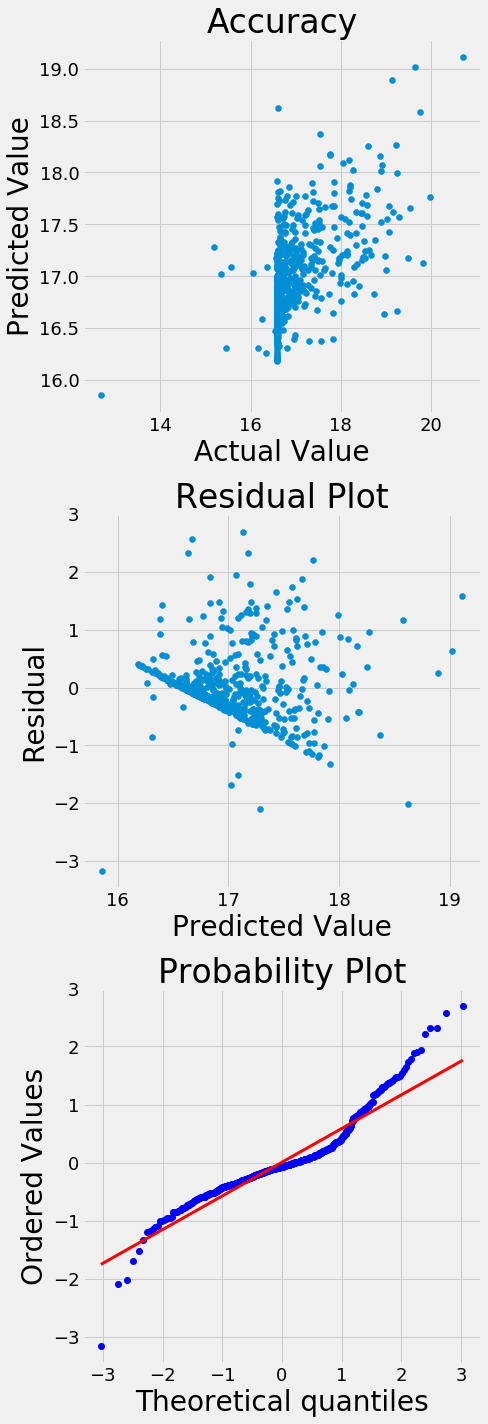

In [29]:
lr_eval(lr_pipe, X_test, y_test)

**Significant improvement in R-squared  
Hard boundary observed in accuracy and residual plots due to few movies below threshold**

In [30]:
lr_pipe.named_steps['model'].alpha_

6.316157894736842

# Model Predictions
Check model predictions against past five best picture winners

In [31]:
# create list of best picture winner indicies
b_pic_idx = [
    df[df['title'].str.contains('12 years a slave')].index[0], 
    df[df['title'].str.contains('birdman')].index[0],
    df[df['title'].str.contains('spotlight')].index[0],
    df[df['title'].str.contains('moonlight')].index[0],
    df[df['title'].str.contains('shape of water')].index[0]
]

In [32]:
# best film titles
b_pic_tit = ['12 Year a Slave', 'Birdman', 'Spotlight', 'Moonlight', 'The Shape of Water']
# best film features
b_pic_feat = X.loc[b_pic_idx, :]
# best picture revenue
b_pic_rev = y[b_pic_idx]

In [33]:
# model predictions
b_pic_predict = lr_pipe.predict(b_pic_feat)

In [34]:
# dataframe converted back from log scale
df_b_pics = pd.DataFrame(
    {'Actual': np.exp(b_pic_rev.values), 'Predicted': np.exp(b_pic_predict)}, 
    index=b_pic_tit
)
df_b_pics

,Actual,Predicted
12 Year a Slave,223721393.0,3.016500e+07
Birdman,122788441.0,3.103696e+07
Spotlight,96463187.0,4.503670e+07
Moonlight,82350399.0,3.006996e+07
The Shape of Water,209889839.0,9.378193e+07


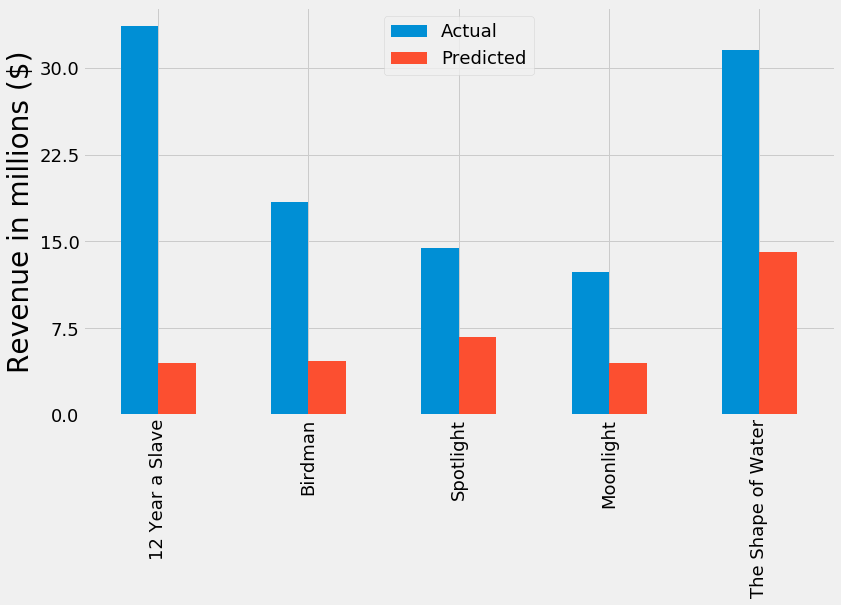

In [35]:
ax = df_b_pics.plot(kind='bar')
ax.set_yticklabels(labels = np.linspace(0, 30, 5))
ax.set_ylabel('Revenue in millions ($)');
# plt.savefig('model_output/mod_pred.png', bbox_inches='tight')

# Model Interpretation

In [36]:
# polynomial feature labels
feature_labels = lr_pipe.named_steps['poly'].get_feature_names(X.columns)

In [37]:
# model coefficients
coefs = lr_pipe.named_steps['model'].coef_

In [38]:
# sort features by weight, return top ten
lr_coef = feat_sort(coefs, feature_labels, 10)
lr_coef

,feat_wgt,positive
num_theaters num_days,0.872039,True
budget^2,0.832818,True
genre_Romance release_month_November,0.599556,True
num_days mpaa_rating_Unrated,0.523315,False
num_days mpaa_rating_PG-13,0.502655,True
budget,0.428541,True
num_days^2,0.410135,True
genre_Romance mpaa_rating_PG-13,0.401964,True
budget num_theaters,0.400435,True
genre_Horror release_month_July,0.378611,False


In [39]:
# define labels for interaction features
features = [
    'No. Theat. and Days', 
    'Budget', 
    'Romance in Nov',
    'No. Days and Unrated',
    'No. Days and PG-13',
    'Budget',
    'No. Days',
    'Romance and PG-13',
    'Budget and No. Theat.',
    'Horror in July'
]

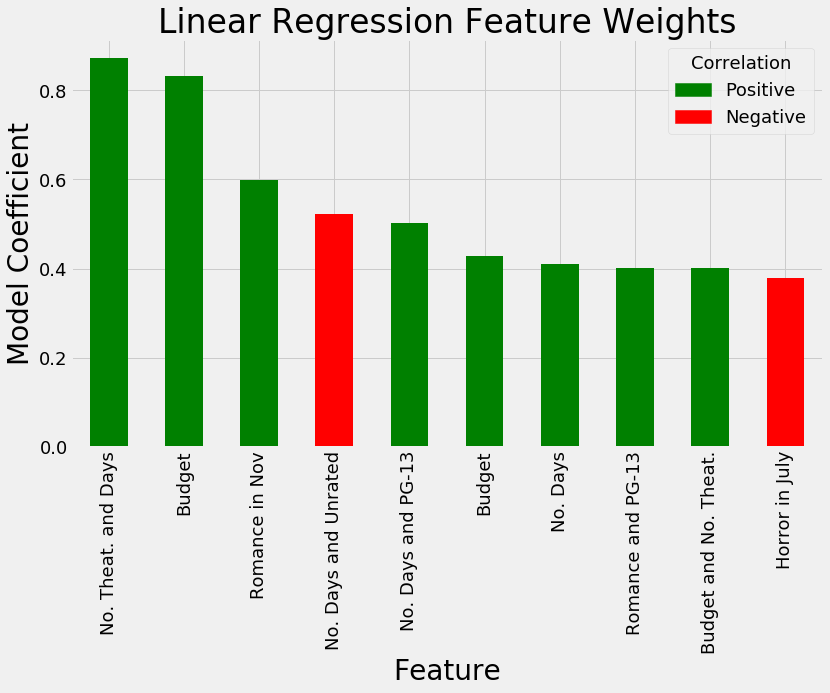

In [40]:
feat_plot(lr_coef, features)
# plt.savefig('model_output/lr_feat.png', bbox_inches='tight')

## Commentary
The feature weights displayed above indicate which factors will favorably or negatively impact the revenue of independent films. Observations:  
- The most significant factors include budget, number of days in the theater and number of theaters that are showing the movie. These factors are intuitive. A larger budget can be used to finance a more appealing film. A film being shown for a longer amount of time and in more locations has much more opportunity to collect revenue.
    - These factors interact with themselves and other features.
    - Interestingly for unrated films, the number of days is correlated with negative performance.
- Movies in the romance genre with a PG-13 ratings and a November release perform well.
- PG-13 movies tend to do well when combined with more days in theaters.
- There is a negative correlation with performance for horror films released in July.

## Top grossing independent films

In [41]:
# return top five movies based on greatest target values
df.iloc[y.nlargest(5).index, :]

,title,distributor,genre,mpaa_rating,release_month,budget,runtime,num_theaters,num_days,dom_gross,intl_gross,disc_gross
2344,the twilight saga: new moon,Summit Entertainment,Romance,PG-13,November,57127674.0,130.0,103.0,133.0,338908370.0,810882795.0,253783924.0
1277,the hunger games: catching fire,Lionsgate,Action / Adventure,PG-13,November,136787475.0,146.0,103.0,133.0,446840540.0,910175179.0,128974497.0
2349,the twilight saga: eclipse,Summit Entertainment,Romance,PG-13,June,76439813.0,124.0,103.0,114.0,337832221.0,785184535.0,240293025.0
1829,the hunger games,Lionsgate,Action / Adventure,PG-13,March,85409897.0,142.0,103.0,168.0,435601892.0,741352277.0,237367287.0
1485,the twilight saga: breaking dawn part 2,Lionsgate/Summit,Romance,PG-13,November,28296713.0,116.0,103.0,112.0,312092822.0,885857385.0,15917987.0


In [42]:
# average values for comparison
df.mean(axis=0)

budget          2.829671e+07
runtime         1.076088e+02
num_theaters    1.037317e+02
num_days        7.643820e+01
dom_gross       8.505410e+06
intl_gross      2.253733e+07
disc_gross      1.591799e+07
dtype: float64

The twighlight series are PG-13 romance films released in November with above average budgets and theater release. These features fit well with the model interpretation. The hunger games series are PG-13 films with wide release and hefty budgets.